In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy import special

# Quantal size estimation

In quantum-starved imaging modalities, the image noise is dominated by the Poisson-distributed quantum noise. Its predictable properties allow estimating the size of individual quanta. While this estimate may not be precise enough to make a strong statement about its physical interpretation, it can be used as a factor in quality control and signal compression.

This notebook explains how to estimate the quantal size in two-photon recordings.

Let $f$ be the true expected number of photons at a given pixel in a given recorded frame.

Then the detector will record the signal 
$$x = \gamma (f + \varepsilon) + b$$

where $\gamma$ and $b$ are the ADC gain and offset, respectively; and $\varepsilon$ is the quantum noise. 

Notably, $\gamma$ expresses the *quantal size*, i.e. the numerical size of a single photon in the recorded signal $x$.

From the Poisson distribution, 
$$\mathop{\mathbb E}\left[\varepsilon\right] = 0$$ and
$$\mathop{\mathbb E}\left[\varepsilon^2\right] = f$$

Then the expected pixel value is 
$$\mu  = \mathop{\mathbb E}\left[x\right] = \gamma f + b$$ 

and the pixel value variance is 
$$
\begin{align}
\sigma^2 = & \mathop{\mathbb E}\left[(x-\mu)^2\right]\\ 
= & \mathop{\mathbb E}\left[(\gamma(f + \varepsilon) + b -\mu)^2\right] \\
= & \mathop{\mathbb E}\left[(\gamma \varepsilon)^2\right] \\
= & \gamma^2 f 
\end{align}
$$ 

Then we can express pixel value variance as a function of its mean as:

$$
\sigma^2 = \gamma^2 f = \gamma (\mu - b) = \gamma \mu - \gamma b
$$

From acquired data, we can estimate the sample means and variances $\hat \mu$ and $\hat \sigma^2$. 
We then use a linear fit to estimate the slope $a_1$ and intercept $a_0$ so that:
$$\hat \sigma^2 \approx  a_1 \hat \mu + a_0$$

Then the quantal size and DC offset can be estimated as
$$\gamma \approx a_1$$ and $$b \approx -a_0/a_1$$

# Grayscale optimization

The recorded signal $x$ above was considered to be real-valued. In reality, acquisition systems *quantize* recorded pixel values into discrete grayscale values. 

Then the recorded signal becomes 
$$
\dot x = [x] = x + d
$$
where $[x]$ expresses the rounding to the nearest intger and $d$ is the quantization error, *i.e.* the difference due to rounding. 

Let $\beta = \frac \delta \sigma$ express the quantization step-to-noise ratio. 

With the rounding operation above, the quantization step is $\delta = 1$ and $\beta = \frac 1 \sigma$.

Large values $\beta$ indicate coarse quantization.

Excessively high quantization results in larger images that are more difficult to compress due to their high entropy.  We ask the question what's the coarsest quantization that produces no reduction in our ability to analyze the signals. 

We will find the largest value of $\beta$ that is still acceptable for all imaging purposes. We ensure that the data remains accurate (unbiased) and precise (no more noisy than before quantization).

### Quantization Bias

Large values of $\beta$, coarse quantization can introduce bias $\eta_\mu$ in estimations of the mean of a signal.

When a varying signal, the quantization bias is

$$
\eta_{\mu} = \mathop{\mathbb E}\left[\dot x - x\right] = \dot \mu - \mu
$$

With $\beta \gg 2$, the quantization can produce biases in the estimation of the mean, resulting in step-like contours. However, with $\beta < 2$ the mean can be estimated accurately after quantization:

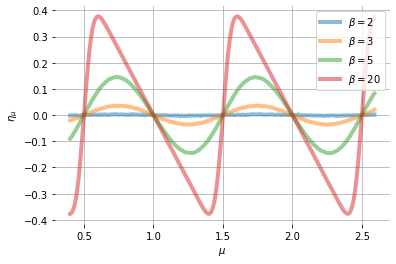

In [111]:
x = np.r_[0.4:2.6:0.01]
betas = [2, 3, 5, 20]
for beta in betas:
    y = np.random.randn(500_000, x.size)/beta
    xr = np.round(x + y).mean(axis=0)  
    plt.plot(x, xr-x, alpha=0.5, lw=4)

plt.box(False)
plt.xlabel('$\mu$')
plt.ylabel('$\eta_{\mu}$')
plt.legend([fr'$\beta={b}$' for b in betas])
plt.grid(True)

$\beta < 2$ provides sufficiently fine quantization to allow accurate estimates of mean values of the signal.
Conversely, in imaging the effect of coarse quantization produces contours within regions of smooth gradient. This happens only with $\beta \gg 2$.

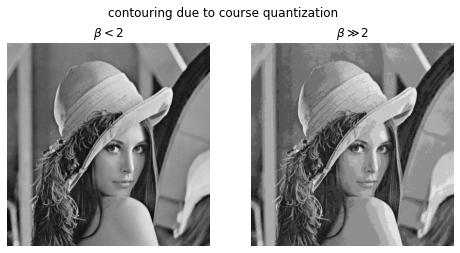

In [112]:
im = plt.imread('lenna.png').mean(axis=2)
im /= im.max()
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].imshow(im, cmap='gray')
ax[0].axis(False)
ax[0].set_title(r'$\beta < 2$')

ax[1].imshow(np.round(im*10), cmap='gray')
ax[1].axis(False)
ax[1].set_title(r'$\beta \gg 2$')

fig.suptitle('contouring due to course quantization');

### Quantization Variance

Coarse quantization may also increase the variance of the recorded signal.

With dynamic signals, the acquisition noise in $x$ and the quantization $d$ can be considered independent random variables. Here $d$ becomes a uniformly distributed random variable on $[-\delta/2, +\delta/2]$.

Then the variance of the quantized signal is

$$
\begin{align}
\dot \sigma^2
= &\mathop{\mathbb{E}}\left[(\dot x - \dot \mu)^2\right] \\
= &\mathop{\mathbb{E}}\left[(x - \mu + d)^2\right] \\
= &\mathop{\mathbb{E}}\left[(x - \mu)^2\right] + \mathop{\mathbb{E}}\left[d^2\right] \\
= & \sigma^2 + \frac 1 \delta \int_{-\delta/2}^{+\delta/2}z^2 dz \\
= & \sigma^2 + \tfrac 1 {12} \delta^2 \\
= & \sigma^2 + \tfrac 1 {12} \beta^2 \sigma^2 \\
= & (1 + \tfrac 1 {12}\beta^2) \sigma^2
\end{align}
$$

or 
$$
\dot \sigma = \sigma \sqrt{1 + \tfrac 1{12}\beta^2} 
$$

The factor $\sqrt{1 + \tfrac 1{12}\beta^2}$ is the relative increase in noise or, conversely, decrease in SNR due to the effect of quantization.

At $\beta=2.0$, quantization results in 15.5% noise increase, which is hardly acceptable.
However, this increase begins to drop rapidly with smaller values of $\beta$:

In [113]:
print(f'β\t SNR change')
for β in 2.0, 1.0, 0.7, 0.5, 0.2:
    print(f'{β} \t {(1 - (1 + β*β/12) ** .5)*100:0.3}%')

β	 SNR change
2.0 	 -15.5%
1.0 	 -4.08%
0.7 	 -2.02%
0.5 	 -1.04%
0.2 	 -0.167%


Accepting that we can tolerate around 1% noise increase due to quantization, we adopt $\beta = 0.5$ as the target quantization granularity.

## Variance equalization

The optimal quantization will be achieved by imposing $\beta=0.5$ across the full range of intensities. 
This means that the quantization step will be finer in the darker portions of the image and larger in the bright.

This can be addressed by a variance-equalizing transformation known as the *Anscombe transform*.

If the variance of the signal $x$ depends on intensity as 
$$
\sigma^2=\gamma (\mu - b)
$$
then we can transform $x$ into its descretized value 

$$\bar x \leftarrow \left\lfloor \frac 2 \beta \sqrt{\frac 1 \gamma  x - b + \tfrac 3 8}\right\rfloor$$

This will result in a discrete image with the noise variance of $1/\beta$ everywhere.

Or using our sample estimates, 
$$
\bar x \leftarrow \left\lfloor \frac 2 \beta \sqrt{  (x + a_0)/a_1 + \tfrac 3 8}\right\rfloor
$$

This grayscale quantization significantly reduces the image bitdepth without sacrificing our ability to evaluate biologically relevant signals. 

## Frequency-based lossless compression

Images produced as the difference of the current frame from a running average, will produce roughly normally-distributed pixel values with the entropy of $H = \frac 1 2 \log_2\frac{2 \pi e}{\beta^2}$ bits per pixel for region areas with little activity. For $\beta = 0.5$, this will be $\approx 3$ bits per pixel. 

In [114]:
import math
β, e, π = 0.5, math.e, math.pi 
print(f"{0.5 * math.log(2*π*e/β**2, 2):0.2} bits/per pixel")

3.0 bits/per pixel


This rate predicts the size of the images after efficient lossless compression in regions of bright fluorescence with no motion or activity. In regions with calcium activity or motion, the bit rate will be higher. In regions with no fluorescence (below the single-photon threshold), the bit rate will be lower. Therefore, it's reasonable to estimate a bit rate of about 2.5/bits per pixel.  Considering that most current systems store the data unpacked in 16-bit values, this will lead to 6.4:1 compression ratio in an effectively lossless scheme. Some formats pack 12-bit or 10-bit data, so the compression rate may be 4:1.

This compression is based purely on the frequencies of single-pixel intensity values in the temporal difference images. Additional gains may be derived from spatial dependencies. 

We must define data compression utilities that are configurable and replaceable to allow for iterative improvements.